# Dataset analysis 

In [2]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import os.path
import re
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
import json
from matplotlib import cm

import tikzplotlib

plt.style.use("seaborn")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [3]:
base_path_raw = os.path.abspath('/media/jan/Jal/haven_raw')
base_path_enhanced = os.path.abspath('/media/jan/Jal/haven_enhanced')

In [4]:
losses = ['unsupervised_rotation_loss', 'rot_point_loss_multi', 'prior_extend', 'separation_loss']
columns = losses + ['mean_dice', 'background'] + [f'L{i}' for i in range(1,6)]
columns = columns + ['name', 'base', 'contrast']

result = pd.DataFrame(columns=columns)

In [5]:
Results_table = pd.DataFrame()
for contrast, base_path in zip(['raw', 'enhanced'], [base_path_raw, base_path_enhanced]):

    for name in os.listdir(base_path):
        print(f'opening {name}')
        if name == 'deleted' or name.endswith('.png'):
            continue
        with open(os.path.join(base_path,name, 'exp_dict.json')) as f:
            exp_dict = json.load(f)
            loss = exp_dict['model']['loss']
            epochs = exp_dict['max_epoch']
            base = exp_dict['model']['base']
            sources = exp_dict['dataset']['sources']
            print(sources)
        if epochs != 55:
            continue
        print(f'epochs : {exp_dict}')
        score_df = pd.read_csv(os.path.join(base_path,name, 'score_df.csv'))
        metrics_df = pd.read_csv(os.path.join(base_path, name, 'test_metrics_df.csv'))
        print(f'Experiment {loss}\nscore : \n{score_df.test_dice.max()}\n{metrics_df}')
        temp = {l : [l in loss] for l in losses}
        temp.update({c : [metrics_df.iloc[i, 4]] for i, c in enumerate(['background', 'L1', 'L2', 'L3', 'L4', 'L5'])})
        temp.update({'mean_dice' : [metrics_df['dice'].mean()]})
        temp.update({'indication' : f'{contrast}\n{base}'})
        temp.update({'name' : name})
        temp.update({'base' : base})
        temp.update({'contrast' : contrast})
        temp = pd.DataFrame.from_dict(temp)
        result = pd.concat([result, temp])


opening deleted
opening 0222478aa7dfdc0489d32d85ee17a1ce
['xVertSeg']
opening 227e2afede4e16c51e8163763c2217e1
['USiegen']
opening 58a033a65a4009b3dbd1be3ca3d83a8c
['MyoSegmenTUM']
opening a850efdf8b4fb88a7046d1cf70810530
['xVertSeg', 'USiegen', 'MyoSegmenTUM']
opening 8fef7f2df1c440edfcdff2301a8c3f16
['xVertSeg', 'USiegen', 'MyoSegmenTUM']
opening 513f53256ddbe4f45e83e1709445f581
['xVertSeg', 'USiegen', 'MyoSegmenTUM']
epochs : {'batch_size': 6, 'dataset': {'bg_points': 5, 'blob_points': 2, 'n_classes': 6, 'name': 'spine_dataset', 'sources': ['xVertSeg', 'USiegen', 'MyoSegmenTUM']}, 'dataset_size': {'test': 'all', 'train': 'all', 'val': 'all'}, 'lr': 0.0001, 'max_epoch': 55, 'model': {'base': 'fcn8_vgg16', 'loss': ['unsupervised_rotation_loss', 'rot_point_loss_multi', 'prior_extend', 'separation_loss'], 'n_channels': 3, 'n_classes': 6, 'name': 'inst_seg'}, 'num_channels': 1, 'optimizer': 'adam'}
Experiment ['unsupervised_rotation_loss', 'rot_point_loss_multi', 'prior_extend', 'separat

In [6]:
result = result.sort_values('mean_dice')
color = cm.Blues([250,100,100,250])
result

,unsupervised_rotation_loss,rot_point_loss_multi,prior_extend,separation_loss,mean_dice,background,L1,L2,L3,L4,L5,name,base,contrast,indication
0,True,True,True,True,0.397950,0.988324,0.252540,0.237762,0.269680,0.345710,0.293682,d3e414d842d2e81f6a724b6261af9690,fcn8_resnet,enhanced,enhanced\nfcn8_resnet
0,True,True,True,True,0.461045,0.991363,0.376983,0.422960,0.349042,0.349024,0.276896,513f53256ddbe4f45e83e1709445f581,fcn8_vgg16,raw,raw\nfcn8_vgg16
0,True,True,True,True,0.470400,0.993339,0.333184,0.308436,0.393001,0.367823,0.426617,513f53256ddbe4f45e83e1709445f581,fcn8_vgg16,enhanced,enhanced\nfcn8_vgg16
0,True,True,True,True,0.475766,0.991469,0.275398,0.416325,0.388203,0.458766,0.324432,d3e414d842d2e81f6a724b6261af9690,fcn8_resnet,raw,raw\nfcn8_resnet


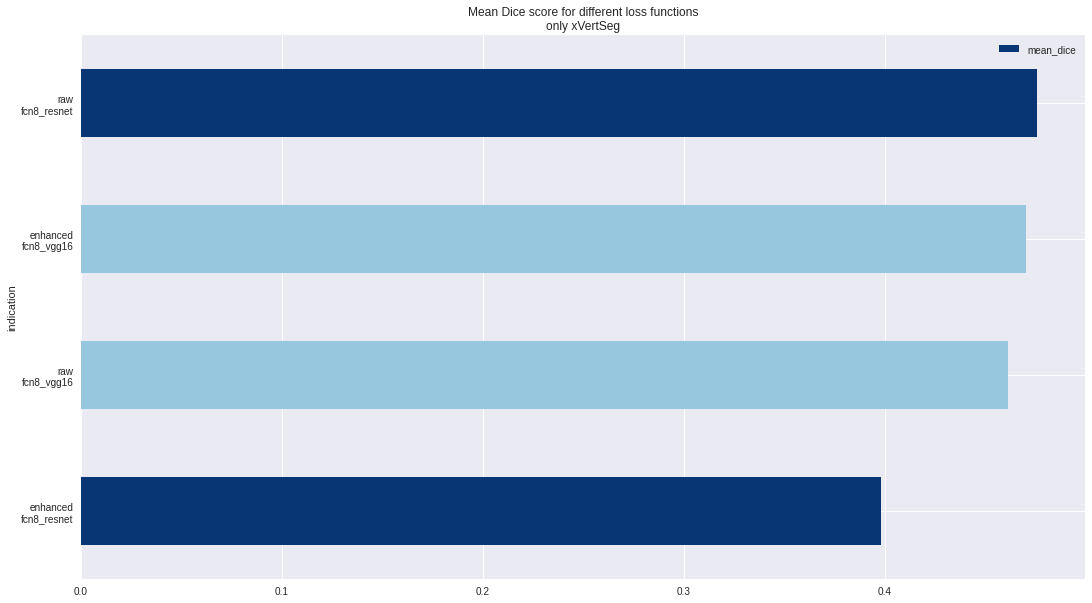

In [7]:
result.plot.barh(x = 'indication', y = 'mean_dice', figsize = (18,10), color = color)
plt.title('Mean Dice score for different loss functions\nxVertSeg, MyoSegmenTUM and USiegen')
plt.savefig(os.path.join(base_path, 'Mean_dice.png'))

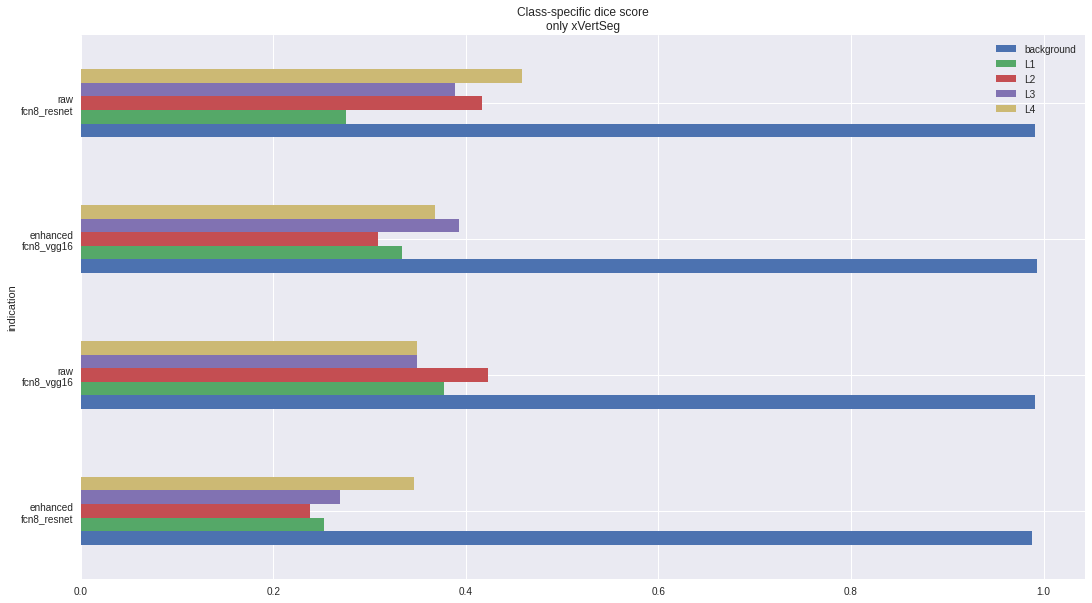

In [8]:
result.plot.barh(x = 'indication', y = ['background'] + [f'L{i}' for i in range(1,5)], figsize = (18,10))
plt.title('Class-specific dice score\nxVertSeg, MyoSegmenTUM and USiegen')
plt.savefig(os.path.join(base_path, 'Class_Specific.png'))

In [9]:
result

,unsupervised_rotation_loss,rot_point_loss_multi,prior_extend,separation_loss,mean_dice,background,L1,L2,L3,L4,L5,name,base,contrast,indication
0,True,True,True,True,0.397950,0.988324,0.252540,0.237762,0.269680,0.345710,0.293682,d3e414d842d2e81f6a724b6261af9690,fcn8_resnet,enhanced,enhanced\nfcn8_resnet
0,True,True,True,True,0.461045,0.991363,0.376983,0.422960,0.349042,0.349024,0.276896,513f53256ddbe4f45e83e1709445f581,fcn8_vgg16,raw,raw\nfcn8_vgg16
0,True,True,True,True,0.470400,0.993339,0.333184,0.308436,0.393001,0.367823,0.426617,513f53256ddbe4f45e83e1709445f581,fcn8_vgg16,enhanced,enhanced\nfcn8_vgg16
0,True,True,True,True,0.475766,0.991469,0.275398,0.416325,0.388203,0.458766,0.324432,d3e414d842d2e81f6a724b6261af9690,fcn8_resnet,raw,raw\nfcn8_resnet
